## Human Protein Multi Label Image Classification Capstone Project

### By Abdeali Jaroli (jaroliabdeali@gmail.com)


## Credits
 
 - Simple CNN Starter (https://www.kaggle.com/aakashns/simple-cnn-starter)
 - Melanoma Competiton: Aug + ResNet/EffNet (LB 0.91) (https://www.kaggle.com/andradaolteanu/melanoma-competiton-aug-resnet-effnet-lb-0-91)
 - Image Classification Basic (https://www.kaggle.com/nachiket273/one-cycle) 

In [2]:
pip install -q efficientnet_pytorch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import torch
import random
import pandas as pd
import numpy as np
import cv2

from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts
from efficientnet_pytorch import EfficientNet
import torchvision.transforms.functional as TF

%matplotlib inline

## Defining the Data sources


In [4]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv'   # Contains dummy labels for test image

The `train.csv` file contains image IDs and labels for training data. Note that this is a multi-label classification problem. Each image can have more than one type of protein.

In [5]:
import os
print(os.listdir("../input"))

['jovian-pytorch-z2g']


In [6]:
!head "{TRAIN_CSV}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


Similarly, `submission.csv` contains image IDs for test data. However, since the goal of this competition is to make predictions for the test set, the `submission.csv` files contains **dummy labels**, which you need to replace with your predictions and sumbit to the competition on the "Submission" tab. In other words, we don't have the labels for the test set.

In [7]:
!head "{TEST_CSV}"

Image,Label
24117,0
15322,0
14546,0
8079,0
13192,0
25927,0
3372,0
21781,0
2847,0


The image files are named `<image-id>.png` and can be found in the respective `train` and `test` folders.

In [8]:
!ls "{TRAIN_DIR}" | head

0.png
1.png
10000.png
10001.png
10005.png
10008.png
10009.png
10012.png
10013.png
10014.png
ls: write error: Broken pipe


Let's load the `train.csv` file into a Pandas dataframe

In [9]:
import pandas as pd
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


Let's also put the textual labels in a dictionary for later use.

In [10]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

To create a tensor from the labels, we will encode the labels as vectors of 1s & 0s. For example, if the labels are `'2 4 5'`, the correspoding vector for it would be `[0, 0, 1, 0, 1, 1, 0, 0, 0, 0]`. Let's define helper funtions to encode labels into tensors and vice versa.

In [11]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)


In [12]:
encode_label('2 4 5')

tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])

In [13]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]))

'2 4 5'

In [14]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]), text_labels=True)

'Nucleoli(2) Nucleoplasm(4) Nucleoli fibrillar center(5)'

## Creating Datasets & Data Loaders

We can now create a custom dataset by extending the `Dataset` class from PyTorch. We need to define the `__len__` and `__getitem__` methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [15]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
#         self.df = pd.read_csv(csv_file) 
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

I tried using different of training, and validation dataset when I train the model and then used the probabilities of the model to do ensemble

In [16]:
# --- Read in Data ---

val_pct = 0.1
val_size = int(val_pct * len(train_df))
train_size = len(train_df) - val_size

# ## version1
# train_data = train_df.iloc[:train_size].reset_index(drop=True)
# valid_data = train_df.iloc[-val_size:].reset_index(drop=True)

#version2
# train_data = train_df.iloc[val_size:].reset_index(drop=True)
# valid_data = train_df.iloc[:val_size].reset_index(drop=True)

#version3
start_step = 8000
valid_data = train_df.iloc[start_step:start_step+val_size].reset_index(drop=True)
train_data = pd.concat([train_df.iloc[:start_step], train_df.iloc[start_step+val_size:]]).reset_index(drop=True)

len(train_data), len(valid_data)

(17313, 1923)

Transforms can be chained using `transforms.Compose`. For instance, you may add `transforms.Resize(128)` before `transforms.ToTensor()` to resize images to size 128x128 before converting them into tensors. See the full list of transforms here: https://pytorch.org/docs/master/torchvision/transforms.html

In [17]:

train_transform = transforms.Compose([  
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, saturation=0.2, contrast=0.2),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.ToTensor()

    ])

train_ds = HumanProteinDataset(train_data, TRAIN_DIR, transform=train_transform)
val_ds = HumanProteinDataset(valid_data, TRAIN_DIR, transform=test_transform)

Let's check how many samples the dataset contains

Let's take a look at a sample image from the dataset. We'll define a function `show_sample` to help us. We will also include the option to invert the image before showing it, because the original images are quite dark.

In [18]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))
    

Here's a sample image without the colors inverted.

Labels: Nuclear speckles(9)


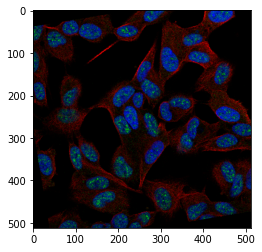

In [19]:
show_sample(*train_ds[0], invert=False)

Here's the same image viewed with the colors inverted

Labels: Nuclear speckles(9)


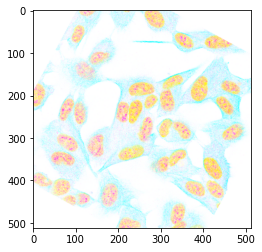

In [20]:
show_sample(*train_ds[0])

### Training & Validation sets

As a good practice, we should split the data into training and validation datasets. Let's fix a seed for PyTorch (to ensure we always get the same validation set), and create the datasets using `random_split`.

In [21]:
torch.manual_seed(10)

I'm using a validation percentage of 10%, but you can use a smaller or larger percentage. One good strategy is to determine a good set of hyperparameters, and then retrain on a smaller validation set for your final submission.

In [22]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

## Data Loaders

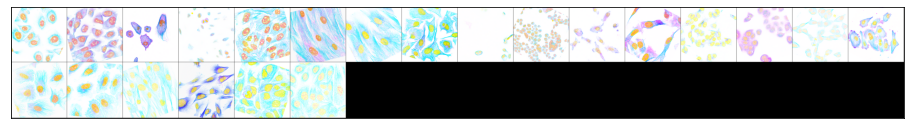

In [23]:
batch_size = 22

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

show_batch(train_dl)

## Computational Model

In [24]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [25]:
ALPHA = 0.25
GAMMA = 2
FOCAL_LOSS = False

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)      
        
        loss = F.binary_cross_entropy(out, targets)
        bce_exp = torch.exp(-loss)
        focal_loss = ALPHA * (1-bce_exp)**GAMMA * loss
        if FOCAL_LOSS: loss = focal_loss
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images) 
        # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        bce_exp = torch.exp(-loss)
        focal_loss = ALPHA * (1-bce_exp)**GAMMA * loss
        
        score = F_score(out, targets)
        if FOCAL_LOSS: loss = focal_loss
            
        return {'val_loss': loss.detach(), 'val_score': score.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [26]:
class EfficientNetwork(MultilabelImageClassificationBase):
    def __init__(self, b4=False, b2=False):
        super().__init__()
        self.b4, self.b2 = b4, b2
        
        # Define Feature part
        if b4:
            self.features = EfficientNet.from_pretrained('efficientnet-b4')
        elif b2:
            self.features = EfficientNet.from_pretrained('efficientnet-b2')
        else:
            self.features = EfficientNet.from_pretrained('efficientnet-b1')
        
        # Define Classification part
        if b4:
            self.classification = nn.Linear(1792, 10)
        elif b2:
            self.classification = nn.Linear(1408, 10)
        else:
            self.classification = nn.Linear(1280, 10)
        
        
    def forward(self, image, prints=False):
        if prints: print('Input Image shape:', image.shape)
        
        image = self.features.extract_features(image)
        if prints: print('Features Image shape:', image.shape)
            
        if self.b4:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1792)
        elif self.b2:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        else:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1280)
        if prints: print('Image Reshaped shape:', image.shape)
        
        out = self.classification(image)
        if prints: print('Out shape:', out.shape)
        
        return torch.sigmoid(out)
    
    

In [27]:
  class Resnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [28]:
model = EfficientNetwork(b4=False, b2=False)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b1


In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

7806994

In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cpu')

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [33]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([22, 3, 512, 512])
out.shape: torch.Size([22, 10])
out[0]: tensor([0.5207, 0.5345, 0.4361, 0.4882, 0.5200, 0.4911, 0.4787, 0.4890, 0.4841,
        0.5030], grad_fn=<SelectBackward0>)


If your kernel runs out of memory here, you might need to reduce your batch size.

## Training the model

In [34]:
from tqdm.notebook import tqdm

In [35]:
num_epochs = 26

es_patience = 5

opt_func = torch.optim.AdamW
lr_patience = 2
lr_factor = 0.2
max_lr = 0.01
lr = 0.0001

weight_decay = 0.01
amsgrad=True

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, max_lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    lrs = []
    valid_loss_min = np.Inf
    model_file_name = 'best_model.pth'
    epochs_no_improve =  0
    
    optimizer = opt_func(model.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=epochs)
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2)

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
            lrs.append(get_lr(optimizer))
      # Validation phase   

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs

        valid_loss = result['val_loss']


        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > es_patience:
                model.epoch_end(epoch, result)
                history.append(result)
                return history  
               
        
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [37]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6997378468513489, 'val_score': 0.15504533052444458}]

In [38]:
%%time
### After all the epochs end, load best_model.pth, reduce learning to 0.00001 and train a little more
# model.load_state_dict(torch.load('best_model.pth'))

history = fit(num_epochs, lr, max_lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/787 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Making predictions & submission
To start with, let's create a helper function to make a prediction on a single image.

In [40]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

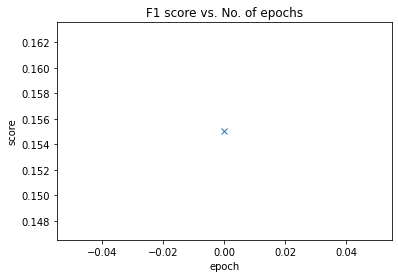

In [41]:
plot_scores(history)

In [42]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

Next, let's create a test dataset using the `submission.csv` file. Note that the file contains dummy labels (always `'0'`). We'll use the same transforms we used for the training set.

In [43]:
#TODO train_transform and test_transform
test_data = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_data, TEST_DIR, transform=test_transform)

In [44]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Let's try predicting the labels for some sample images

Prediction:  tensor([0.0658, 0.0583, 0.0945, 0.0757, 0.4138, 0.0208, 0.1955, 0.0846, 0.0300,
        0.0310], grad_fn=<SelectBackward0>)
Labels: 


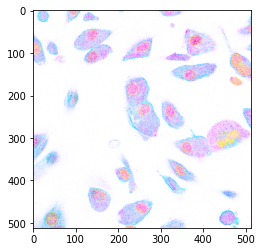

In [45]:
predict_single(test_dataset[100][0])

Prediction:  tensor([0.0625, 0.0510, 0.0872, 0.0703, 0.4039, 0.0185, 0.1951, 0.0821, 0.0276,
        0.0266], grad_fn=<SelectBackward0>)
Labels: 


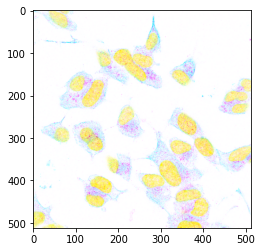

In [46]:
predict_single(test_dataset[74][0])

## Creating a submission file

In [47]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size*4, num_workers=2, pin_memory=True), device)

Saving the prediction in raw probabilities instead of classes to use for stacking later.

In [48]:

@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)      
    return  [x.numpy() for x in batch_probs]
#     return [decode_target(x) for x in batch_probs]

In [50]:
test_preds = predict_dl(test_dl, model)

  0%|          | 0/94 [00:00<?, ?it/s]

KeyboardInterrupt: 

Let us know create a submission file with these predictions

In [ ]:
len(test_preds)

In [ ]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.head()

We can now save it batck to CSV, and download the file from the sidebar (check the output folder)

In [ ]:
sub_fname = 'efficientb1_0.86_2jul.csv'
submission_df.to_csv(sub_fname, index=False)

 Read prediction files contain `Image` and probabilities and do ensemble.

In [ ]:
# import pandas as pd
# import numpy as np

# df = pd.read_csv('../efficientb1_submission_0.8246.csv')
# df2 = pd.read_csv('../efficientb1_submission_0.8209.csv')
# df3 = pd.read_csv('../efficientb2_submission_0.81_2jul.csv')
# df4 = pd.read_csv('../efficientb2_submission_0.80.csv')
# df5 = pd.read_csv('../efficientb1_0.86_2jul.csv')
# df6 = pd.read_csv('../efficientb1_0.8125.csv')

# def e_to_double(num_str):
#     return [float(s.strip()) for s in num_str.strip('[]').split(' ') if s.strip() != '']

# def decode_target(target, text_labels=False, threshold=0.5):
#     result = []
#     for i, x in enumerate(target):
#         if (x >= threshold):
#             if text_labels:
#                 result.append(labels[i] + "(" + str(i) + ")")
#             else:
#                 result.append(str(i))
#     return ' '.join(result)

In [ ]:
df['probs'] = df.Label.apply(lambda x: e_to_double(x))
df['Label'] = df.probs.apply(lambda x: decode_target(x))

df2['probs'] = df2.Label.apply(lambda x: e_to_double(x))
df2['Label'] = df2.probs.apply(lambda x: decode_target(x))

df3['probs'] = df3.Label.apply(lambda x: e_to_double(x))
df3['Label'] = df3.probs.apply(lambda x: decode_target(x))

df4['probs'] = df4.Label.apply(lambda x: e_to_double(x))
df4['Label'] = df4.probs.apply(lambda x: decode_target(x))

df5['probs'] = df5.Label.apply(lambda x: e_to_double(x))
df5['Label'] = df5.probs.apply(lambda x: decode_target(x))

df6['probs'] = df6.Label.apply(lambda x: e_to_double(x))
df6['Label'] = df6.probs.apply(lambda x: decode_target(x))

In [ ]:
join_df = df[['Image','probs']].merge(df2[['Image','probs']], on='Image', how='inner', suffixes=('', '_a'))
join_df = join_df[['Image','probs','probs_a', 'probs_b']].merge(df3[['Image','probs']], on='Image', how='inner', suffixes=('', '_b'))
join_df = join_df[['Image','probs','probs_a', 'probs_b', 'probs_c']].merge(df4[['Image','probs']], on='Image', how='inner', suffixes=('', '_c'))
join_df = join_df[['Image','probs','probs_a', 'probs_b', 'probs_c', 'probs_d']].merge(df5[['Image','probs']], on='Image', how='inner', suffixes=('', '_d'))
join_df = join_df.merge(df6[['Image','probs']], on='Image', how='inner', suffixes=('', '_e'))

## ensemble

In [ ]:
lst_add = []
for n, row in join_df.iterrows():
    add_prob = np.array(row['probs'] * 2) + (np.array(row['probs_a']) + np.array(row['probs_b']) + np.array(row['probs_c']) + np.array(row['probs_d']) + np.array(row['probs_e'])
    lst_add.append(list(add_prob / 6))

In [ ]:
join_df['avg'] = lst_add
join_df['Label'] = join_df.avg.apply(lambda x: decode_target(x))
en = join_df[['Image', 'Label', 'avg']]

# fill the missing label with lower threshold
en['Label'] = np.where(en.Label == '', en.avg.apply(lambda x: decode_target(x, threshold=0.46)), en.Label) 
print(len(en[en.Label == '']))
en['Label'] = np.where(en.Label == '', en.avg.apply(lambda x: decode_target(x, threshold=0.445)), en.Label)
print(len(en[en.Label == '']))

# finally fill with max probabilities
en['Label'] = np.where(en.Label == '', en.avg.apply(lambda x: np.argmax(x)), en.Label)

In [ ]:
final_df = en[['Image', 'Label']]
final_df.to_csv('/Users/mimi/Desktop/ensem5_6items_thres_2jul.csv',index=False)

You can also use the "Save Version" button on Kaggle itself, to save a copy on your Kaggle profile.